This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
lower = np.array([1.0])
upper = np.array([1.7])
prior = priors.Uniform(lower, upper)

In [3]:
# we define a few hyper parameters here
np.random.seed(13)
n = 200 # total number of data points for NF
n_sims = n  # total number of points for drawing
n_class = 1 # number of different cosmologies for the training
q_prior = np.linspace(1.0, 1.7, n_sims) #np.random.uniform(0, 1, n)
q_fid = np.asarray([1.35]) #np.random.uniform(0, 1, 1)

In [4]:
q_fid 

array([1.35])

In [5]:
# in order to perform the compressions, we need a few things
n_vec = 50
mu = np.arange(1, n_vec+1)/(q_fid * n_vec)
Cinv = n_vec**2*np.eye(n_vec)/ np.arange(1, n_vec+1)
dmudt = -np.arange(1, n_vec+1)/(q_fid**2 * n_vec)
dmudt = np.reshape(dmudt, [1, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [6]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
#q_fid = q_fid  # new observation, different from the compression
np.random.seed(13)
q_fid_obs = 1.2
d_vec_obs = np.zeros((1, n_vec))
for j in range(1, n_vec+1):
    d_vec_obs[0, j-1] = np.random.gamma(j / q_fid_obs**2, q_fid_obs / n_vec)

# we also create the data for the training
d_vec_q = np.zeros((n_sims, n_vec))
for i, q in enumerate(q_prior):
    for j in range(1, n_vec+1):
        d_vec_q[i, j-1] = np.random.gamma(j / q**2, q / n_vec)
    
d_vec_obs_keep = np.copy(d_vec_obs)
print(d_vec_q.shape, d_vec_obs.shape)

(200, 50) (1, 50)


In [7]:
d_vec_obs

array([[0.02740799, 0.02425176, 0.05803965, 0.12531366, 0.11820649,
        0.18044246, 0.06354602, 0.15880653, 0.12826348, 0.22199581,
        0.19673581, 0.20077193, 0.40083408, 0.16043108, 0.34455872,
        0.2473932 , 0.29512485, 0.42549664, 0.18947907, 0.37066438,
        0.54373514, 0.30408247, 0.33389361, 0.43180655, 0.27640528,
        0.394077  , 0.56991472, 0.68138134, 0.4666655 , 0.39298143,
        0.50840275, 0.57787691, 0.50493595, 0.73006275, 0.84611151,
        0.63589771, 0.54886192, 0.41798861, 0.55249331, 0.71734376,
        0.79969479, 0.6656209 , 0.66076301, 0.60961445, 0.64335071,
        0.64914912, 0.84060476, 0.69669686, 0.88955313, 0.94543232]])

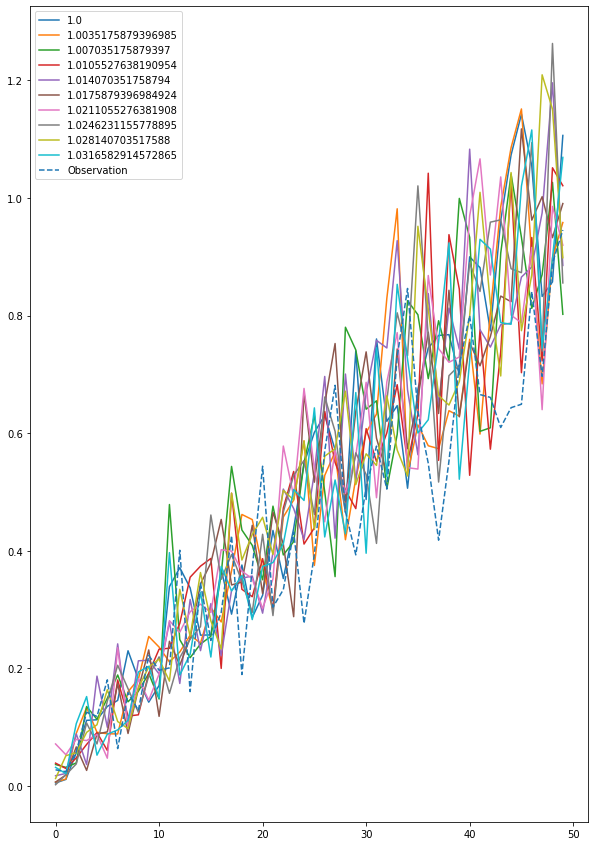

In [8]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(10):
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
#for index in range(n):
#    plt.plot(np.arange(n_vec), d_vec[index],)
plt.plot(np.arange(n_vec), d_vec_obs[0], label='Observation', linestyle='--')
plt.legend();

In [9]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the noise realisations
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec_q[index]))
summaries_noise = np.asarray(summaries_noise)
summary_obs = compressor(d_vec_obs[0])
summary_obs = np.reshape(summary_obs, [1, 1])

In [10]:
compressor(d_vec_obs[0])

array([1.14385931])

In [11]:
compressed_data = summary_obs[0]

sim_params = np.reshape(q_prior, [-1, 1])

sim_compressed_data = summaries_noise

#Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array(q_fid)

## Create ensemble of NDEs


In [12]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=1, n_data=1, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

## Create DELFI object

In [13]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,  
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['q'], 
                            results_dir = "./attempt_results")

## Load simulations into DELFI object

In [14]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

# Train the networks

In [15]:
DelfiEnsemble.train_ndes()

In [16]:
# this should give us the log-likelihood
n_bins = 10000
posterior_params = np.linspace(1.0, 1.7, n_bins)
sim_params = np.copy(posterior_params)
likelihood_arr = np.zeros((n_bins, 2))
for index, q_value in enumerate(sim_params):
    likelihood_arr[index, :] = q_value, DelfiEnsemble.log_likelihood_stacked(q_value, compressed_data)

In [17]:
likelihood_arr = likelihood_arr[likelihood_arr[:,0].argsort()]
likelihood_arr[:, 1] = np.exp(likelihood_arr[:, 1])  # return to likelihood
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [18]:
import scipy.special as sps
theo_post = np.zeros((n_bins, 2))
for i, q in enumerate(sim_params):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

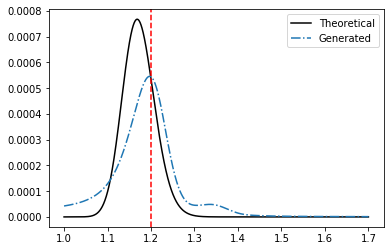

In [19]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')

In [ ]:
# old numerical compression
n_vec = 50
d_vec = np.zeros((n, n_vec))
for i in range(n):
    for j in range(1, n_vec+1):
        d_vec[i, j-1] = np.random.gamma(j / q_fid**2, q_fid / n_vec)

mu_ = np.mean(d_vec, axis=0)
cov_ = np.cov(d_vec, rowvar=False)
Cinv_ = np.linalg.inv(cov_)

h = 0.01
q_fid_p = q_fid + h
d_vec_p = np.zeros((n, n_vec))
for i in range(n):
    for j in range(1, n_vec+1):
        d_vec_p[i, j-1] = np.random.gamma(j / q_fid_p**2, q_fid_p / n_vec)

mu_p_ = np.mean(d_vec_p, axis=0)
dmudt_ = (mu_p_ - mu_)/h
dmudt_ = np.reshape(dmudt_, [1, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu_, Cinv = Cinv_, dmudt = dmudt_)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None